Install Dependencies

In [ ]:
!pip install shap praat-parselmouth librosa soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 30.2 MB/s eta 0:00:00


Install & Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc

# Base ML models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GRU, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

Upload & Load Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])

if "name" in df.columns:
    df = df.drop(columns=["name"])

display(df.head())
print("Shape:", df.shape)

Saving parkinsons.csv to parkinsons (1).csv


,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


Shape: (195, 23)


Preprocessing

In [ ]:
X = df.drop("status", axis=1).values
y = df["status"].values

feature_names = df.drop("status", axis=1).columns.tolist()

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (156, 22) Test: (39, 22)


Base ML Models

In [ ]:
results = []
trained_models = {}

base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel="rbf", probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "LDA": LinearDiscriminantAnalysis()
}

for name, model in base_models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)

    results.append({"Model": name, "Type": "Base", "Accuracy": acc})
    trained_models[name] = model

print("Base models done.")

Base models done.


prepare sequence data

In [ ]:
X_seq = X.reshape(X.shape[0], X.shape[1], 1)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_seq, y, test_size=0.2, random_state=42, stratify=y
)

ANN

In [ ]:
ann = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])
ann.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
ann.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

pred = (ann.predict(X_test) > 0.5).astype(int)
acc = accuracy_score(y_test, pred)

results.append({"Model": "ANN", "Type": "Proposed", "Accuracy": acc})
trained_models["ANN"] = ann

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


cnn

In [ ]:
cnn = Sequential([
    Conv1D(64, 3, activation="relu", input_shape=(Xc_train.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(1, activation="sigmoid")
])
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn.fit(Xc_train, yc_train, epochs=30, batch_size=16, verbose=0)

pred = (cnn.predict(Xc_test) > 0.5).astype(int)
acc = accuracy_score(yc_test, pred)

results.append({"Model": "CNN", "Type": "Proposed", "Accuracy": acc})
trained_models["CNN"] = cnn

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


CNN+GRU

In [ ]:
cnn_gru = Sequential([
    Conv1D(64, 3, activation="relu", input_shape=(Xc_train.shape[1], 1)),
    MaxPooling1D(2),
    GRU(32),
    Dense(1, activation="sigmoid")
])
cnn_gru.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn_gru.fit(Xc_train, yc_train, epochs=30, batch_size=16, verbose=0)

pred = (cnn_gru.predict(Xc_test) > 0.5).astype(int)
acc = accuracy_score(yc_test, pred)

results.append({"Model": "CNN + GRU", "Type": "Proposed", "Accuracy": acc})
trained_models["CNN + GRU"] = cnn_gru

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


CNN + Graph (Correlation)

In [ ]:
corr = np.corrcoef(X_train.T)
X_graph = X @ corr

Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    X_graph, y, test_size=0.2, random_state=42, stratify=y
)

cnn_graph = Sequential([
    Dense(128, activation="relu", input_shape=(Xg_train.shape[1],)),
    Dense(1, activation="sigmoid")
])
cnn_graph.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn_graph.fit(Xg_train, yg_train, epochs=30, batch_size=16, verbose=0)

pred = (cnn_graph.predict(Xg_test) > 0.5).astype(int)
acc = accuracy_score(yg_test, pred)

results.append({"Model": "CNN + Graph", "Type": "Proposed", "Accuracy": acc})
trained_models["CNN + Graph"] = cnn_graph

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


gru

In [ ]:
gru = Sequential([
    GRU(32, input_shape=(Xc_train.shape[1], 1)),
    Dense(1, activation="sigmoid")
])
gru.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
gru.fit(Xc_train, yc_train, epochs=30, batch_size=16, verbose=0)

pred = (gru.predict(Xc_test) > 0.5).astype(int)
acc = accuracy_score(yc_test, pred)

results.append({"Model": "GRU", "Type": "Proposed", "Accuracy": acc})
trained_models["GRU"] = gru

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Transformer

In [ ]:
def build_transformer(input_shape):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=4, key_dim=16)(inputs, inputs)
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs, outputs)

transformer = build_transformer((Xc_train.shape[1], 1))
transformer.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
transformer.fit(Xc_train, yc_train, epochs=30, batch_size=16, verbose=0)

pred = (transformer.predict(Xc_test) > 0.5).astype(int)
acc = accuracy_score(yc_test, pred)

results.append({"Model": "Transformer", "Type": "Proposed", "Accuracy": acc})
trained_models["Transformer"] = transformer

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Autoencoder + Classifier

In [ ]:
inp = Input(shape=(X_train.shape[1],))
enc = Dense(64, activation="relu")(inp)
enc = Dense(32, activation="relu")(enc)
dec = Dense(64, activation="relu")(enc)
dec = Dense(X_train.shape[1], activation="linear")(dec)

autoencoder = Model(inp, dec)
encoder = Model(inp, enc)

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(X_train, X_train, epochs=50, batch_size=16, verbose=0)

X_train_enc = encoder.predict(X_train)
X_test_enc = encoder.predict(X_test)

ae_clf = Sequential([
    Dense(32, activation="relu", input_shape=(X_train_enc.shape[1],)),
    Dense(1, activation="sigmoid")
])
ae_clf.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
ae_clf.fit(X_train_enc, y_train, epochs=30, batch_size=16, verbose=0)

pred = (ae_clf.predict(X_test_enc) > 0.5).astype(int)
acc = accuracy_score(y_test, pred)

results.append({"Model": "Autoencoder + Classifier", "Type": "Proposed", "Accuracy": acc})
trained_models["Autoencoder + Classifier"] = ae_clf

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Deep Belief Network

In [ ]:
dbn = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])
dbn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
dbn.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0)

pred = (dbn.predict(X_test) > 0.5).astype(int)
acc = accuracy_score(y_test, pred)

results.append({"Model": "DBN", "Type": "Proposed", "Accuracy": acc})
trained_models["DBN"] = dbn

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Final Table

In [ ]:
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
display(results_df)

,Model,Type,Accuracy
3,KNN,Base,0.948718
2,Random Forest,Base,0.948718
5,LDA,Base,0.948718
6,ANN,Proposed,0.923077
13,DBN,Proposed,0.923077
1,SVM,Base,0.897436
9,CNN + Graph,Proposed,0.871795
0,Logistic Regression,Base,0.871795
12,Autoencoder + Classifier,Proposed,0.846154
7,CNN,Proposed,0.846154


Box plots of all tables,models

Run 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Run 2/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Run 3/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Run 4/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Run 5/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


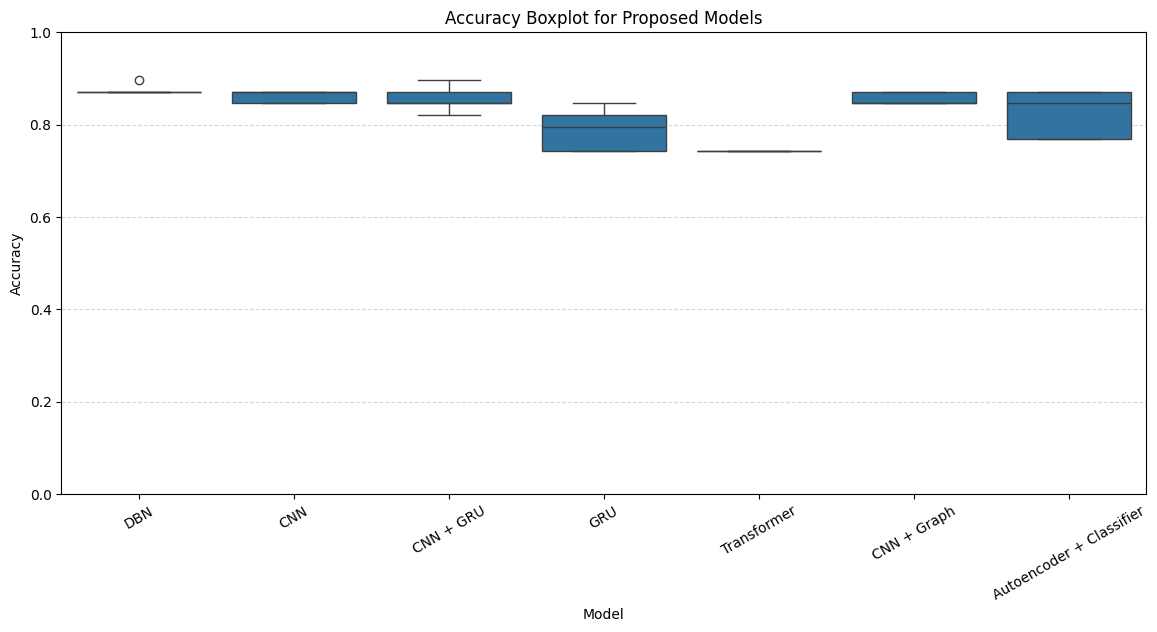

In [ ]:
boxplot_records = []

for run in range(5):
    print(f"Run {run+1}/5")

    # New split each run
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=42+run, stratify=y
    )

    # For sequence models
    X_tr_seq = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
    X_te_seq = X_te.reshape(X_te.shape[0], X_te.shape[1], 1)

    # ---------- DBN ----------
    dbn = Sequential([
        Dense(128, activation="relu", input_shape=(X_tr.shape[1],)),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    dbn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    dbn.fit(X_tr, y_tr, epochs=20, batch_size=16, verbose=0)
    pred = (dbn.predict(X_te) > 0.5).astype(int)
    boxplot_records.append({"Model": "DBN", "Accuracy": accuracy_score(y_te, pred)})

    # ---------- CNN ----------
    cnn = Sequential([
        Conv1D(64, 3, activation="relu", input_shape=(X_tr_seq.shape[1], 1)),
        MaxPooling1D(2),
        Flatten(),
        Dense(1, activation="sigmoid")
    ])
    cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    cnn.fit(X_tr_seq, y_tr, epochs=20, batch_size=16, verbose=0)
    pred = (cnn.predict(X_te_seq) > 0.5).astype(int)
    boxplot_records.append({"Model": "CNN", "Accuracy": accuracy_score(y_te, pred)})

    # ---------- CNN + GRU ----------
    cnn_gru = Sequential([
        Conv1D(64, 3, activation="relu", input_shape=(X_tr_seq.shape[1], 1)),
        MaxPooling1D(2),
        GRU(32),
        Dense(1, activation="sigmoid")
    ])
    cnn_gru.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    cnn_gru.fit(X_tr_seq, y_tr, epochs=20, batch_size=16, verbose=0)
    pred = (cnn_gru.predict(X_te_seq) > 0.5).astype(int)
    boxplot_records.append({"Model": "CNN + GRU", "Accuracy": accuracy_score(y_te, pred)})

    # ---------- GRU ----------
    gru = Sequential([
        GRU(32, input_shape=(X_tr_seq.shape[1], 1)),
        Dense(1, activation="sigmoid")
    ])
    gru.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    gru.fit(X_tr_seq, y_tr, epochs=20, batch_size=16, verbose=0)
    pred = (gru.predict(X_te_seq) > 0.5).astype(int)
    boxplot_records.append({"Model": "GRU", "Accuracy": accuracy_score(y_te, pred)})

    # ---------- Transformer ----------
    def build_transformer(input_shape):
        inputs = Input(shape=input_shape)
        x = MultiHeadAttention(num_heads=4, key_dim=16)(inputs, inputs)
        x = LayerNormalization()(x)
        x = GlobalAveragePooling1D()(x)
        x = Dense(64, activation="relu")(x)
        outputs = Dense(1, activation="sigmoid")(x)
        return Model(inputs, outputs)

    transformer = build_transformer((X_tr_seq.shape[1], 1))
    transformer.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    transformer.fit(X_tr_seq, y_tr, epochs=20, batch_size=16, verbose=0)
    pred = (transformer.predict(X_te_seq) > 0.5).astype(int)
    boxplot_records.append({"Model": "Transformer", "Accuracy": accuracy_score(y_te, pred)})

    # ---------- CNN + Graph ----------
    corr = np.corrcoef(X_tr.T)
    X_tr_graph = X_tr @ corr
    X_te_graph = X_te @ corr

    cnn_graph = Sequential([
        Dense(128, activation="relu", input_shape=(X_tr_graph.shape[1],)),
        Dense(1, activation="sigmoid")
    ])
    cnn_graph.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    cnn_graph.fit(X_tr_graph, y_tr, epochs=20, batch_size=16, verbose=0)
    pred = (cnn_graph.predict(X_te_graph) > 0.5).astype(int)
    boxplot_records.append({"Model": "CNN + Graph", "Accuracy": accuracy_score(y_te, pred)})

    # ---------- Autoencoder + Classifier ----------
    inp = Input(shape=(X_tr.shape[1],))
    enc = Dense(64, activation="relu")(inp)
    enc = Dense(32, activation="relu")(enc)
    dec = Dense(64, activation="relu")(enc)
    dec = Dense(X_tr.shape[1], activation="linear")(dec)

    autoencoder = Model(inp, dec)
    encoder = Model(inp, enc)

    autoencoder.compile(optimizer="adam", loss="mse")
    autoencoder.fit(X_tr, X_tr, epochs=30, batch_size=16, verbose=0)

    X_tr_enc = encoder.predict(X_tr)
    X_te_enc = encoder.predict(X_te)

    ae_clf = Sequential([
        Dense(32, activation="relu", input_shape=(X_tr_enc.shape[1],)),
        Dense(1, activation="sigmoid")
    ])
    ae_clf.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    ae_clf.fit(X_tr_enc, y_tr, epochs=20, batch_size=16, verbose=0)

    pred = (ae_clf.predict(X_te_enc) > 0.5).astype(int)
    boxplot_records.append({"Model": "Autoencoder + Classifier", "Accuracy": accuracy_score(y_te, pred)})

# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_records)

plt.figure(figsize=(14,6))
sns.boxplot(data=boxplot_df, x="Model", y="Accuracy")
plt.title("Accuracy Boxplot for Proposed Models")
plt.ylim(0, 1)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=30)
plt.show()

roc curves

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


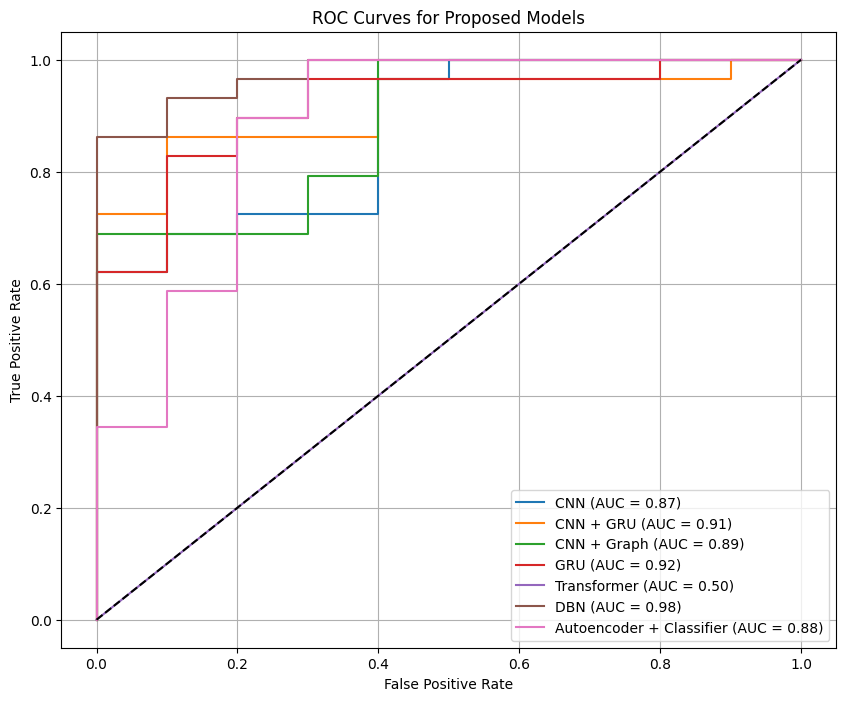

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

proposed_names = [
    "CNN",
    "CNN + GRU",
    "CNN + Graph",
    "GRU",
    "Transformer",
    "DBN",
    "Autoencoder + Classifier"
]

# Prepare different input versions
X_test_seq = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# For CNN + Graph
corr = np.corrcoef(X_train.T)
X_test_graph = X_test @ corr

# For Autoencoder + Classifier
X_test_enc = encoder.predict(X_test)

plt.figure(figsize=(10,8))

for name in proposed_names:
    model = trained_models[name]

    # Select correct input
    if name in ["CNN", "CNN + GRU", "GRU", "Transformer"]:
        X_input = X_test_seq
    elif name == "CNN + Graph":
        X_input = X_test_graph
    elif name == "Autoencoder + Classifier":
        X_input = X_test_enc
    else:  # DBN
        X_input = X_test

    # Get probabilities / scores
    preds = model.predict(X_input)
    probs = preds.reshape(-1)

    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Diagonal line
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Proposed Models")
plt.legend()
plt.grid(True)
plt.show()

save best model

In [ ]:
proposed_names = [
    "CNN",
    "CNN + GRU",
    "CNN + Graph",
    "GRU",
    "Transformer",
    "DBN",
    "Autoencoder + Classifier"
]

# Filter only proposed models
proposed_df = results_df[results_df["Model"].isin(proposed_names)].copy()

# Sort by Accuracy (descending)
proposed_df = proposed_df.sort_values(by="Accuracy", ascending=False)

best_model_name = proposed_df.iloc[0]["Model"]
best_model = trained_models[best_model_name]

print("✅ Best Proposed Model:", best_model_name)
print("✅ Best Accuracy:", proposed_df.iloc[0]["Accuracy"])

✅ Best Proposed Model: DBN
✅ Best Accuracy: 0.9230769230769231


In [ ]:
import pickle

# Save best trained model
pickle.dump(best_model, open("parkinson_model.pkl", "wb"))

# Save scaler (for preprocessing in backend)
pickle.dump(scaler, open("scaler.pkl", "wb"))

# Save feature names (optional but useful)
pickle.dump(feature_names, open("feature_names.pkl", "wb"))

print("💾 Saved files:")
print(" - parkinson_model.pkl")
print(" - scaler.pkl")
print(" - feature_names.pkl")

💾 Saved files:
 - parkinson_model.pkl
 - scaler.pkl
 - feature_names.pkl


SHAP Explainability

Running SHAP for: DBN
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 0/39 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3269/3269 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

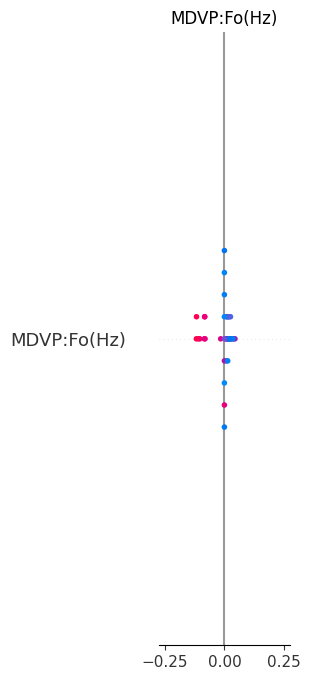

In [ ]:
X_bg = X_train[:50]
X_exp = X_test[:50]

print("Running SHAP for:", best_model_name)

explainer = shap.KernelExplainer(best_model.predict, X_bg)
shap_values = explainer.shap_values(X_exp)

shap.summary_plot(shap_values, X_exp, feature_names=feature_names)

In [43]:
plt.savefig("accuracy_comparison.png", dpi=150, bbox_inches="tight")
plt.savefig("roc_curves.png", dpi=150, bbox_inches="tight")
plt.savefig("boxplot_proposed.png", dpi=150, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>